In [1]:
from diffusers import StableDiffusionPipeline, StableDiffusionImageVariationPipeline, UniPCMultistepScheduler
import torch
import glob
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from diffusers import UNet2DConditionModel
from torch.optim import AdamW

model_id = "lambdalabs/sd-image-variations-diffusers"
device = 'cuda'
pipe = StableDiffusionImageVariationPipeline.from_pretrained(model_id, requires_safety_checker=False)
# pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(device)
pipe.enable_model_cpu_offload()
print(pipe)
path_file = '/home/rmuproject/rmuproject/data/**/*.png'
path_list = glob.glob(path_file, recursive=True)

/home/rmuproject/rmuproject/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]An error occurred while trying to fetch /home/rmuproject/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /home/rmuproject/.cache/huggingface/hub/models--lambdalabs--sd-image-variations-diffusers/snapshots/42bc0ee1726b141d49f519a6ea02ccfbf073db2e/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  17%|█▋        | 1/6 [00:01<00:05,  1.15s/it]An error occurred while trying to fetch /home/rmuproject/.cache/huggingface/hub/models--

StableDiffusionImageVariationPipeline {
  "_class_name": "StableDiffusionImageVariationPipeline",
  "_diffusers_version": "0.32.2",
  "_name_or_path": "lambdalabs/sd-image-variations-diffusers",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    "transformers",
    "CLIPVisionModelWithProjection"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}



Previewing batch:


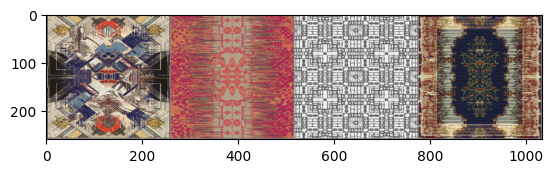

In [2]:
from datasets import load_dataset
import torchvision

dataset_name = "/home/rmuproject/rmuproject/data"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)

X shape: torch.Size([4, 3, 256, 256])


/tmp/ipykernel_139540/3807800429.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))


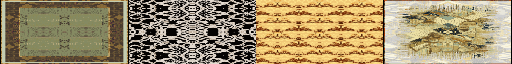

In [7]:
import numpy as np
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im
xb = next(iter(train_dataloader))["images"].to(device)[:8]
print("X shape:", xb.shape)
show_images(xb).resize((8 * 64, 64), resample=Image.NEAREST)

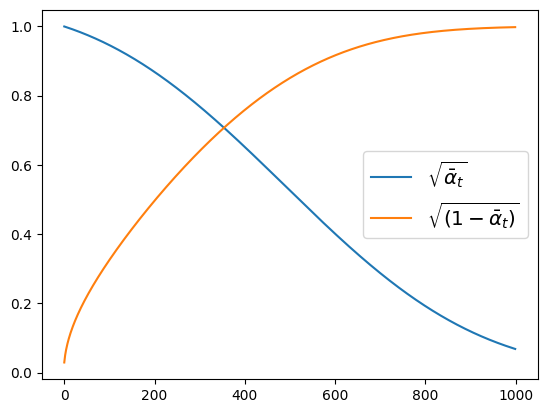

In [10]:
noise_scheduler = pipe.scheduler
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")